## Physics Informed Neural Networks to Approximate Solution of PDEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, TensorDataset

# Adapt this import to your specific directory tree.
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)
    def init_xavier(self):
        
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)


In [4]:
input_data = torch.from_numpy(np.load("input.npy")).type(torch.float32)
input_mu = torch.from_numpy(np.load("input_mu.npy")).type(torch.float32)
output_data = torch.from_numpy(np.load("output.npy")).type(torch.float32)
print(input_data.shape)
print(input_mu.shape)
print(output_data.shape)
print(torch.max(output_data))
print(torch.min(output_data))

torch.Size([64, 100, 100, 3])
torch.Size([64, 2])
torch.Size([64, 100, 100])
tensor(2.5407e-05)
tensor(-2.5407e-05)


In [5]:
total_input = []
for i in range (input_data.shape[0]):
    for j in range (input_data.shape[1]):
        for k in range (input_data.shape[1]):
            total_input.append(np.append(input_data[i][j][k][:-1].flatten().numpy(), input_mu[i].flatten().numpy() ))
print(total_input[0])
print(total_input[0].shape)
print(type(total_input[0]))

[-1.         -1.         -0.09366927 -0.0783205 ]
(4,)
<class 'numpy.ndarray'>


In [6]:
total_input = np.vstack(total_input)
print(type(total_input))


<class 'numpy.ndarray'>


In [7]:
total_input = torch.from_numpy(total_input)


In [8]:
def normalize(t):
    mean, std, var = torch.mean(t), torch.std(t), torch.var(t)
    t1  = (t-mean)/std   
    return t1

def denormlize(t, org_t):
    mean, std, var = torch.mean(org_t), torch.std(org_t), torch.var(org_t)
    t1 = t*std + mean
    return t1

total_output = torch.flatten(output_data)
total_output_norm = normalize(total_output)
print(torch.max(total_output_norm))
# test_denorm = denormlize(total_output_norm, total_output)
# print(total_output.shape)
# print(torch.sum(test_denorm == total_output))

# print(total_output.shape)
# print(total_input.shape)

tensor(3.2559)


In [9]:
ip_shape = 4
op_shape = 1
model = NeuralNet(input_dimension=ip_shape,
                            output_dimension=op_shape,
                            n_hidden_layers=4,
                            neurons=20)

model = model.to(device)

In [10]:
optimizer_ADAM = optim.Adam(model.parameters(),
                            lr=float(0.005))

ratio_train = 0.8                            
n_train = int(np.round(len(total_input) * ratio_train))

train_input = total_input[:n_train].to(device)
train_output = total_output_norm[:n_train].to(device)
test_input = total_input[n_train:].to(device)
test_output = total_output_norm[n_train:].to(device)

batch_size = 128

training_set = DataLoader(TensorDataset(train_input, train_output), batch_size=batch_size, shuffle=False)
testing_set = DataLoader(TensorDataset(test_input, test_output), batch_size=batch_size, shuffle=False)



print(train_input.shape)
print(train_output.shape)
print(test_output.shape)
print(test_input.shape)

torch.Size([512000, 4])
torch.Size([512000])
torch.Size([128000])
torch.Size([128000, 4])


In [11]:
def fit(model, training_set, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            def closure():
                
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                # Item 1. below
                loss = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, )) ** p) 
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        if verbose: print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history
epochs = 10
hist = fit(model= model, training_set=training_set, num_epochs=epochs, optimizer=optimizer_ADAM, p=2, verbose=True)

################################  0  ################################
Loss:  0.088518234177056
################################  1  ################################
Loss:  0.06657396555448941
################################  2  ################################
Loss:  0.055868862878793155
################################  3  ################################
Loss:  0.04943966314442514
################################  4  ################################
Loss:  0.04337333335005678
################################  5  ################################
Loss:  0.03866345235984772
################################  6  ################################
Loss:  0.03599000520867412
################################  7  ################################
Loss:  0.033405100146046605
################################  8  ################################
Loss:  0.03163422065784107
################################  9  ################################
Loss:  0.030294268385739998


## Evaluate


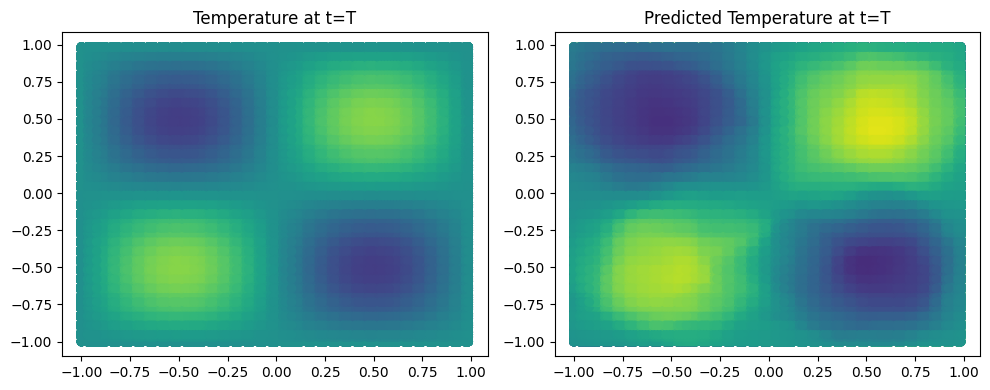

In [14]:
test_input = test_input.to(device)
model = model.to(device)
test_output = test_output.to(device=device)
test_output_denorm = denormlize(test_output, total_output)
with torch.no_grad():
    op_pred = model(test_input).cpu()
    op_pred_denorm = denormlize(op_pred, total_output)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Create a figure with two subplots
    # print(test_input[:, 0].shape)
    # print(test_input[:, 1].shape)
    # print(test_output.shape)
    axes[0].scatter(test_input[:, 0].cpu(), test_input[:,1].cpu(), c=test_output_denorm.cpu())
    axes[0].set_title('Temperature at t=T')

    axes[1].scatter(test_input[:,0].cpu(), test_input[:,1].cpu(), c=op_pred)
    axes[1].set_title('Predicted Temperature at t=T')

    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()  # Display the plot
    